### Third solution

For the third solution I decided to use pre-trained word embeddings (using glove with 300d vectors).  
In order to run it all, download glove and change ```GLOVE_PATH```

I've commented all lines of code that may take a lot of time in order to avoid rewriting weights and glove file.  
Uncomment if needed

In [10]:
import pandas as pd
import numpy as np

from copy import deepcopy

from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from gensim.models import KeyedVectors

GLOVE_PATH = "glove.6B/glove.6B.300d.txt"
GLOVE_W2V_FORMAT = "glove_w2v.txt"

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [11]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Preparing embeddings

In [3]:
# _ = glove2word2vec(GLOVE_PATH, GLOVE_W2V_FORMAT)

In [12]:
model = KeyedVectors.load_word2vec_format(GLOVE_W2V_FORMAT)

In [13]:
class Vectorizer(object):

    def __init__(self, model):
        
        self.model = model
        self.dim = model.vector_size

    def transform(self, word):
      
        if word in self.model.vocab.keys():
            word_vec = self.model.word_vec(word)
                    
            return np.array(word_vec)
        
        else:
            return None

In [14]:
vectorizer = Vectorizer(model)

In [19]:
vectorizer.transform('test')

array([ 2.6640e-02,  7.3666e-01,  1.4519e-01, -1.2378e+00, -7.8431e-02,
        1.1878e-01,  1.1072e-01, -5.7459e-01, -5.0329e-01, -2.0694e+00,
        5.6273e-01, -6.5392e-02,  2.6165e-01, -2.9559e-01, -1.3630e-01,
        6.6476e-01,  1.1782e-01,  8.5784e-02, -3.1630e-01, -4.7456e-01,
       -3.1628e-01, -6.1258e-01,  1.6968e-01,  2.9080e-01,  1.5166e-02,
        1.9775e-01,  2.6749e-01,  1.0875e-01, -8.6687e-02, -5.8117e-01,
        1.9078e-02, -3.5914e-01, -2.6973e-01, -7.0312e-02, -7.1556e-01,
        1.1675e-01, -5.7603e-01,  2.2745e-01, -5.4766e-01,  1.5907e-01,
        3.0659e-01,  3.1730e-01,  1.1656e-01, -1.0250e-01,  1.1470e-03,
       -2.2274e-01, -5.3550e-01, -4.3364e-01, -2.0306e-01, -3.5997e-01,
        3.5991e-01, -2.0668e-01,  1.4845e-01,  7.7065e-02,  5.2591e-02,
        3.8939e-01,  9.9486e-02, -5.3198e-01, -1.0236e-01,  3.1587e-01,
        2.4825e-01, -3.3952e-01,  8.6676e-02, -3.4517e-01,  4.2221e-01,
        3.3158e-01,  3.3441e-01, -3.4035e-01,  4.9647e-02,  4.55

### Classifying

In [84]:
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation, Conv1D
from keras.layers import LSTM, GlobalAveragePooling1D, SpatialDropout1D
from keras.datasets import imdb
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten, GlobalMaxPool1D

from keras.regularizers import l1, l2

from sklearn.utils import class_weight

In [21]:
def yes_no_int(text):
    if text == "Yes":
        return 1
    else:
        return 0

In [22]:
train_df['labels'] = train_df['labels'].apply(yes_no_int)
test_df['labels'] = test_df['labels'].apply(yes_no_int)

In [23]:
texts = list(train_df['text'])
texts.extend(test_df['text'])
len(texts)

4649

In [24]:
labels = list(train_df['labels'])
labels.extend(test_df['labels'])
len(labels)

4649

In [25]:
tokenizer = Tokenizer(num_words=6000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [26]:
tokenizer.fit_on_texts(texts)

In [28]:
vocab_size = len(tokenizer.word_index)

In [29]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = vectorizer.transform(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 train_df['labels'].unique(),
                                                 train_df['labels'])
print(class_weights)

[0.94349845 1.06369983]


In [31]:
x_test = tokenizer.texts_to_sequences(test_df['text'].values)
x_test = pad_sequences(x_test, maxlen=216, truncating='post')
x_train = tokenizer.texts_to_sequences(train_df['text'].values)
x_train = pad_sequences(x_train, maxlen=216, truncating='post')

### Model

I have already used max pooling in solution 2, which was the best result. Here I'm trying to improve score  
by using 1D Convolutional Neural Network along with Glove word embedding. Conv1D seems to be a successful solution for deriving sequence features.

In [108]:
model = Sequential()
model.add(Embedding(vocab_size, 300, 
                       weights=[embedding_matrix], 
                       input_length=x_train.shape[1], 
                       trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(300, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 216, 300)          2062800   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 212, 128)          192128    
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 300)               38700     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 301       
Total params: 2,293,929
Trainable params: 231,129
Non-trainable params: 2,062,800
_________________________________________________________________


In [109]:
checkpointer = ModelCheckpoint(filepath="weights_sol3a.hdf5", verbose=1, save_best_only=True)

In [110]:
history = model.fit(x_train, train_df['labels'],
          class_weight=class_weights,
          batch_size=256,
          epochs=12,
          validation_data=(x_test, test_df['labels']),
          callbacks=[checkpointer])

Train on 3657 samples, validate on 992 samples
Epoch 1/12
3657/3657 [==============================] - 16s 4ms/step - loss: 0.6740 - acc: 0.5824 - val_loss: 0.4834 - val_acc: 0.7954

Epoch 00001: val_loss improved from inf to 0.48340, saving model to weights_sol3a.hdf5
Epoch 2/12
3657/3657 [==============================] - 16s 4ms/step - loss: 0.5115 - acc: 0.7525 - val_loss: 0.4549 - val_acc: 0.8165

Epoch 00002: val_loss improved from 0.48340 to 0.45488, saving model to weights_sol3a.hdf5
Epoch 3/12
3657/3657 [==============================] - 16s 4ms/step - loss: 0.4195 - acc: 0.8130 - val_loss: 0.4012 - val_acc: 0.8256

Epoch 00003: val_loss improved from 0.45488 to 0.40121, saving model to weights_sol3a.hdf5
Epoch 4/12
3657/3657 [==============================] - 15s 4ms/step - loss: 0.3248 - acc: 0.8679 - val_loss: 0.4339 - val_acc: 0.8034

Epoch 00004: val_loss did not improve from 0.40121
Epoch 5/12
3657/3657 [==============================] - 17s 5ms/step - loss: 0.2390 - acc

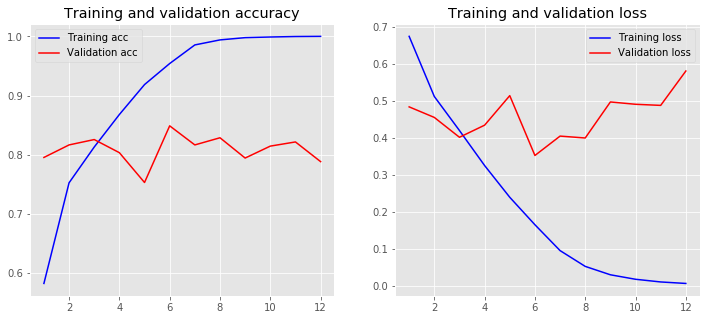

In [111]:
plot_history(history)

In [112]:
model.load_weights("weights_sol3a.hdf5")

In [113]:
score, acc = model.evaluate(x_test, test_df['labels'], batch_size=512)
print('Test loss:', score)
print('Test accuracy:', acc)

992/992 [==============================] - 1s 1ms/step
Test loss: 0.3520056095815474
Test accuracy: 0.8487903187351842


Here I've reached 84.8% accuracy

### Results

Based on all three solutions I've made, I would recommend to use 3rd solution as it is the most accurate and still it doesn't require a lot of time and computing power to train.